## 데이터 분할 분석 - 경기경기_양주_지호삼계탕

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('ResideHistory.xlsx', sheet_name=None, index_col=0)
dt = '경기_양주_지호삼계탕'
d_h = data[dt]
d_h.set_index('datetime', inplace=True)
del d_h['date']
del d_h['time']
del d_h['state']
d_h = d_h.sort_values('datetime', ascending=True)
d_h

,history
datetime,
2022-06-11 08:44:47,45
2022-06-21 03:22:24,80
2022-06-21 03:22:24,80
2022-06-22 03:22:14,75
2022-06-22 03:22:14,75
...,...
2023-04-12 01:19:07,75
2023-04-12 02:19:05,75
2023-04-12 03:19:04,75


In [3]:
# Differencing
diff_d_h = d_h.copy()
diff_d_h = diff_d_h['history'].diff()
diff_d_h = diff_d_h.dropna()
print('### Differenced Data ###') 
print(diff_d_h)

### Differenced Data ###
datetime
2022-06-21 03:22:24    35.0
2022-06-21 03:22:24     0.0
2022-06-22 03:22:14    -5.0
2022-06-22 03:22:14     0.0
2022-06-23 03:22:06    -5.0
                       ... 
2023-04-12 01:19:07     0.0
2023-04-12 02:19:05     0.0
2023-04-12 03:19:04     0.0
2023-04-12 04:19:18    -3.0
2023-04-12 05:19:08     0.0
Name: history, Length: 1498, dtype: float64


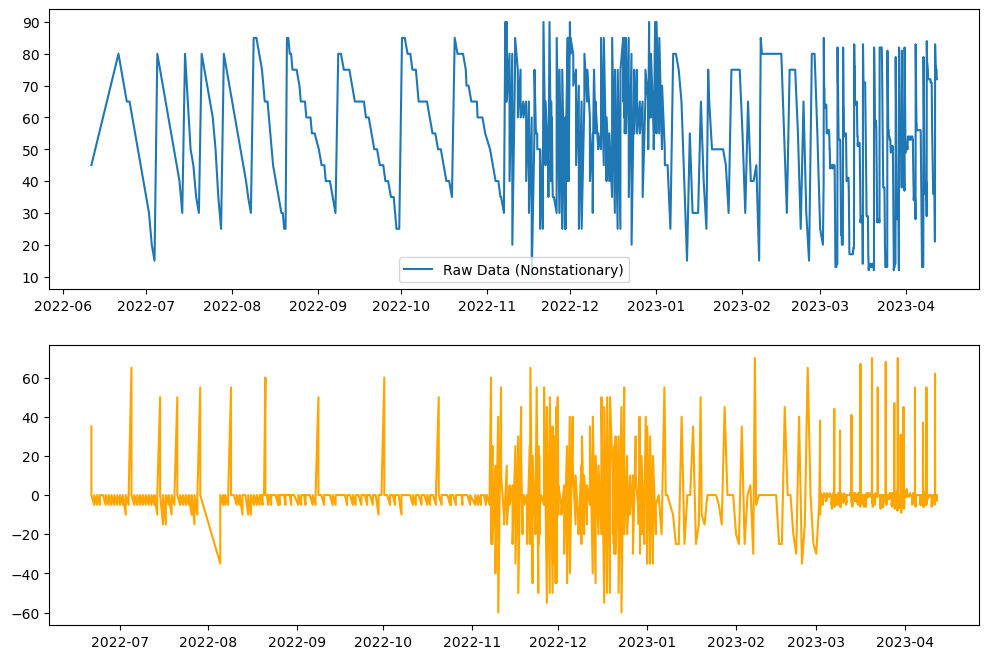

In [4]:
#Differenced data plot
plt.figure(figsize=(12,8)) 
plt.subplot(211)
plt.plot(d_h['history'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_d_h, 'orange') # first difference (t - (t-1)) plt.legend(['Differenced Data (Stationary)'])
plt.show()

# 차분
###  ● 차분 데이터를 통해 공급과 사용량을 구분
###  ● 15 이상의 데이터를 공급으로 간주하고 0으로 한다.
###  ● 15 미만 0 이상의 데이터는 자연스러운 현상이라 간주한다.

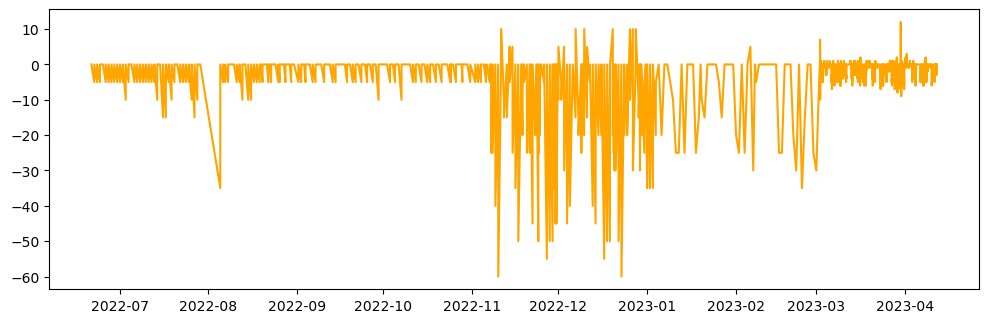

In [5]:
diff_d_h[diff_d_h >= 15] = 0
plt.figure(figsize=(12,8)) 
plt.subplot(212)
plt.plot(diff_d_h, 'orange') # first difference (t - (t-1)) plt.legend(['Differenced Data (Stationary)'])
plt.show()

# Groupby, Weekly
###  1. 주간 데이터의 합을 7로 나누어 하루 사용량을 구한다.
###  2. if 사용량이 0이거나 음수 같은 경우 나누어 주면 inf나 음수가 발생하는데 이 때, 고정값(150)으로 정의한다.
###  3. 첫번째와 마지막 값은 정확히 구간안의 값을 산출하는데 어려움이 있으므로 첫번째 값과 마지막을 제거한다.

<AxesSubplot:xlabel='datetime'>

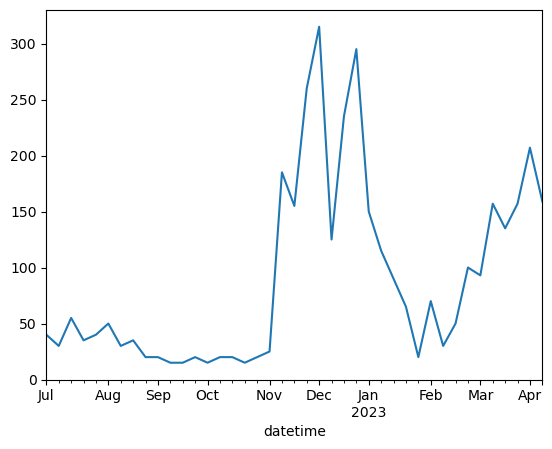

In [6]:
diff_d_h_weekly = -diff_d_h.resample('W').sum()
diff_d_h_weekly = diff_d_h_weekly.dropna()
del diff_d_h_weekly[diff_d_h_weekly.index.min()]
del diff_d_h_weekly[diff_d_h_weekly.index.max()]
#print(diff_d_h_weekly)
diff_d_h_weekly.plot()

<AxesSubplot:xlabel='datetime'>

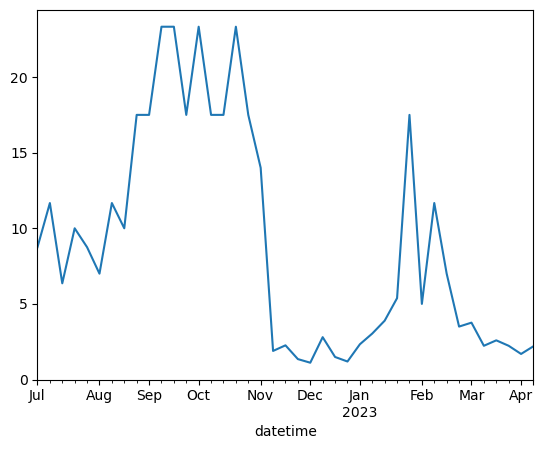

In [7]:
diff_cycle = round(50*7/(diff_d_h_weekly),2)
#print(diff_cycle)
diff_cycle.plot()

###  ● upper bound 값을 cycle

In [8]:
def date_to_fraction(date):
    result = []
    for d in date:
        year = d.year
        month = d.month
        day = d.day

        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

        if month < 1 or month > 12:
            raise ValueError("Invalid month value")

        days_to_month = days_in_month[month-1]
        day_of_month = sum(days_in_month[:month - 1]) + day
        #result.append(day_of_month)
        result.append(month + (day-1)/days_to_month)
    return result
def date_toc_fraction(date):
    result = []
    for d in date:
        year = d.year
        month = d.month
        day = d.day

        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

        if month < 1 or month > 12:
            raise ValueError("Invalid month value")

        days_to_month = days_in_month[month-1]
        day_of_month = sum(days_in_month[:month - 1]) + day
        result.append(day_of_month)
#         result.append(month + (day-1)/days_to_month)
    return result

###  ● Time Series 데이터를 non time series 데이터로 변환시킨다.
        ex) 1월 3일 -> 1월 - 31  -> 1 + 3/(31+1)

In [9]:
import pandas as pd
import numpy as np
H = nontime_date = date_to_fraction(diff_cycle.index)
W = diff_cycle.values
# Convert nontime_date to a pandas DataFrame
nontime_date = pd.DataFrame(nontime_date)
F = np.concatenate([[H], [W]])
tr_F = F.T
# Convert H and W to numpy arrays
H = np.array(H)
W = np.array(W)

# Sort H and W by ascending order of H
sorted_indices = np.argsort(H)
sorted_H = H[sorted_indices]
sorted_W = W[sorted_indices]

# Transpose the arrays
F = np.vstack((sorted_H, sorted_W)).T

# 푸리에 역변환
###  ● 푸라애 변환 : 시간이나 공간에 대한 함수를 시간 또는 공간 주파수 성분으로 분해하는 변환
        sin 함수와  cos 함수를 무한으로 나열한 값으로 일정한 주기를 가진다.
###  ● 푸라애 역변환 : 주파수를 통해 시간이나 공간에 대한 함수로 전환하는 변환
###  ● 다음 데이터들은 1년이란 주기를 가진다고 가정한다.
###  ● 푸리에 역변환의 원활성을 위해 non time series 데이터를 오름차순으로 나열한다.
###  ● 푸리에 변환값과 실제값은 처음에는 다소 차이가 크나 선형회귀를 통해 적절한 값으로 보정해준다.
###  ● 푸리에 변환으로 인해 음수로 된 값을 min 값으로 변환해주는등 약간의 보정 작업을 한다.

In [10]:
import matplotlib.pyplot as plt
from numpy import arange, ones, pi
from scipy import cos, sin
from scipy.fftpack import fft, fftfreq, ifft
data = F
# 주파수 구하기
N = data.shape[0]
dt = data[1, 0] - data[0, 0]
freq = np.fft.fftfreq(N, d=dt)

# 푸리에 변환하기
yf = fft(data[:, 1])
xf = freq

# 푸리에 근사치 구하기
num_coeff = 10 # 사용할 계수 수
yf_approx = np.zeros_like

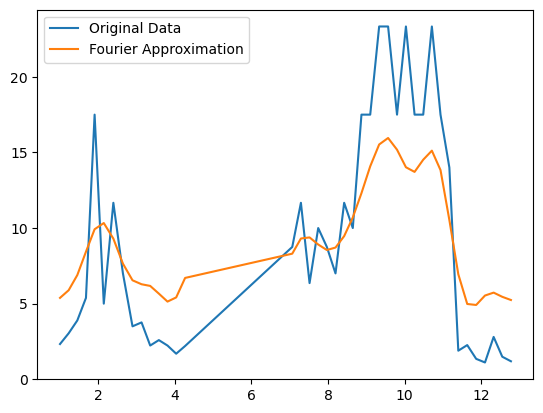

In [11]:
# 계수 추출
yf_trunc = np.zeros_like(yf)
yf_trunc[:num_coeff] = yf[:num_coeff]

# 역변환
y_approx = np.real(ifft(yf_trunc))

# 플롯
plt.plot(data[:, 0], data[:, 1], label='Original Data')
plt.plot(data[:, 0], y_approx, label='Fourier Approximation')
plt.legend()
plt.show()


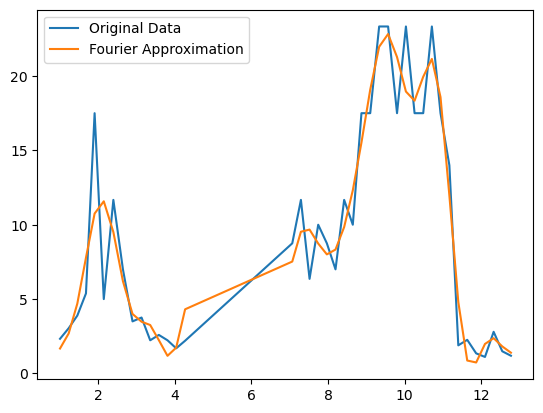

In [12]:
def fsl(x,a,b):
    return a*x+b
from scipy.optimize import curve_fit
import numpy as np
H = y_approx
W =  data[:, 1]
# 선형회귀를 통한 fitting
popt, pcov = curve_fit(fsl, H, W)

modelf = lambda x: fsl(x, *popt)

plt.plot(data[:, 0], data[:, 1], label='Original Data')
plt.plot(data[:, 0], fsl(H, *popt), label='Fourier Approximation')
plt.legend()
plt.show()

In [13]:
#푸리에 변환값 날짜별로 받아오기
def fslvalue_per_day(x1, x2):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    x = x1 + x2/(days_in_month[x1 - 1]+1)
    yf_trunc = np.zeros_like(yf)
    yf_trunc[:num_coeff] = yf[:num_coeff]
    y_interp = np.interp(x, data[:, 0], np.real(ifft(yf_trunc)))
    return y_interp

#날짜에 따른 잔량 변화 예측
def remainby_cycle(x,remain):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    while remain >=10:
        fsl_cycle_value = fsl(fslvalue_per_day(*x), *popt)
        if fsl_cycle_value < min(data[:,1]):
            fsl_cycle_value = min(data[:,1])
        used_gas = 50/fsl_cycle_value
        # 40, 30, 20 경고
        if remain>40 and remain - used_gas <= 40:
            print( "40 Warning",x[0],".",x[1], " : ",round(remain - used_gas,3))
        elif remain>30 and remain - used_gas <= 30:
            print( "30 Warning",x[0],".",x[1], " : ",round(remain - used_gas,3))
        elif remain>20 and remain - used_gas <= 20:
            print( "20 Warning",x[0],".",x[1], " : ",round(remain - used_gas,3))
        remain = remain - used_gas
        #print( x[0],".",x[1], " : ",round(remain,3))
        if remain <=10:
            break
        x[1] = x[1]+1
        # 날짜 처리
        if x[1] > days_in_month[x[0]-1]:
            x[1] = x[1] - days_in_month[x[0]-1]
            x[0] = x[0]+1
        if x[0] > 12:
            x[0] = x[0]-12
    print( x[0],".",x[1], " : ",round(remain,3))
    return x 

In [15]:
# 날짜 입력
x = [9, 8]
# 잔량 입력
remain = 80
remainby_cycle(x,remain)

40 Warning 9 . 25  :  39.163
30 Warning 9 . 29  :  29.358
20 Warning 10 . 3  :  18.86
10 . 7  :  8.092


[10, 7]